# Canucks Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 7 # canucks

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              38652 non-null  int64  
 1   dimCustomerMasterId       38652 non-null  int64  
 2   customerNumber            38652 non-null  object 
 3   year                      38652 non-null  object 
 4   productGrouping           38652 non-null  object 
 5   totalSpent                38652 non-null  float64
 6   recentDate                38652 non-null  object 
 7   attendancePercent         38652 non-null  float64
 8   renewedBeforeDays         38652 non-null  int64  
 9   isBuyer                   38652 non-null  object 
 10  source_tenure             38652 non-null  int64  
 11  tenure                    38652 non-null  int64  
 12  distToVenue               38652 non-null  float64
 13  totalGames                38652 non-null  int64  
 14  recenc

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          38652 non-null  int64  
 1   dimCustomerMasterId   38652 non-null  int64  
 2   customerNumber        38652 non-null  object 
 3   year                  38652 non-null  object 
 4   productGrouping       38652 non-null  object 
 5   totalSpent            38652 non-null  float64
 6   recentDate            38652 non-null  object 
 7   attendancePercent     38652 non-null  float64
 8   renewedBeforeDays     38652 non-null  int64  
 9   isBuyer               38652 non-null  object 
 10  source_tenure         38652 non-null  int64  
 11  tenure                38652 non-null  int64  
 12  distToVenue           38652 non-null  float64
 13  totalGames            38652 non-null  int64  
 14  recency               38652 non-null  int64  
 15  missed_games_1     

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (34787, 47)
Unseen Data For Predictions: (3865, 47)
Data for Modeling (A Class): (34787, 47)
Unseen Data For Predictions: (3865, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(38652, 30)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attendancePercent    38652 non-null  float64
 1   source_tenure        38652 non-null  int64  
 2   tenure               38652 non-null  int64  
 3   totalGames           38652 non-null  int64  
 4   missed_games_1       38652 non-null  int64  
 5   missed_games_2       38652 non-null  int64  
 6   missed_games_over_2  38652 non-null  int64  
 7   send_email           38652 non-null  int64  
 8   openToSendRatio      38652 non-null  float64
 9   clickToSendRatio     38652 non-null  float64
 10  clickToOpenRatio     38652 non-null  float64
 11  isNextYear_Buyer     38652 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 3.5 MB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,attendancePercent,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,send_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,isNextYear_Buyer
attendancePercent,1.00,0.01,0.30,-0.01,-0.28,-0.34,-0.38,0.18,0.18,0.17,0.09,-0.14
source_tenure,0.01,1.00,0.31,0.38,0.27,0.20,0.11,0.10,0.08,-0.02,-0.05,0.27
tenure,0.30,0.31,1.00,-0.12,-0.34,-0.38,-0.25,0.21,0.31,0.30,0.15,-0.31
totalGames,-0.01,0.38,-0.12,1.00,0.62,0.39,0.16,0.37,-0.04,-0.15,-0.09,0.45
missed_games_1,-0.28,0.27,-0.34,0.62,1.00,0.57,0.32,-0.04,-0.17,-0.25,-0.17,0.44
missed_games_2,-0.34,0.20,-0.38,0.39,0.57,1.00,0.35,-0.16,-0.18,-0.22,-0.15,0.35
missed_games_over_2,-0.38,0.11,-0.25,0.16,0.32,0.35,1.00,-0.17,-0.16,-0.19,-0.13,0.19
send_email,0.18,0.10,0.21,0.37,-0.04,-0.16,-0.17,1.00,0.23,0.17,0.18,0.12
openToSendRatio,0.18,0.08,0.31,-0.04,-0.17,-0.18,-0.16,0.23,1.00,0.46,-0.03,-0.12
clickToSendRatio,0.17,-0.02,0.30,-0.15,-0.25,-0.22,-0.19,0.17,0.46,1.00,0.45,-0.15


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (30922, 12)
Unseen Data For Predictions: (7730, 12)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "send_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio"
    ]
)

,Description,Value
0,session_id,5178
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(30922, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


({'parameter': 'Hyperparameters',
  'auc': 'AUC',
  'confusion_matrix': 'Confusion Matrix',
  'threshold': 'Threshold',
  'pr': 'Precision Recall',
  'error': 'Prediction Error',
  'class_report': 'Class Report',
  'rfe': 'Feature Selection',
  'learning': 'Learning Curve',
  'manifold': 'Manifold Learning',
  'calibration': 'Calibration Curve',
  'vc': 'Validation Curve',
  'dimension': 'Dimensions',
  'feature': 'Feature Importance',
  'feature_all': 'Feature Importance (All)',
  'boundary': 'Decision Boundary',
  'lift': 'Lift Chart',
  'gain': 'Gain Chart',
  'tree': 'Decision Tree',
  'ks': 'KS Statistic Plot'},
 False,
 -1,
 [],
 'isNextYear_Buyer',
 18388    1
 25594    1
 9020     0
 23696    0
 19725    0
         ..
 21811    1
 19096    1
 20649    0
 3759     0
 29670    0
 Name: isNextYear_Buyer, Length: 24737, dtype: int64,
        attendancePercent  source_tenure  tenure  totalGames  missed_games_1  \
 18388           0.718750         8760.0   589.0        39.0          

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.8617,0.9386,0.9030,0.8280,0.8638,0.7238,0.7267,0.1030
9,Extreme Gradient Boosting,0.8574,0.9368,0.8963,0.8253,0.8593,0.7152,0.7178,0.9690
2,Gradient Boosting Classifier,0.8550,0.9336,0.8845,0.8287,0.8556,0.7103,0.7119,0.7950
0,Ada Boost Classifier,0.8487,0.9273,0.8842,0.8190,0.8503,0.6979,0.7001,0.2140
7,Random Forest Classifier,0.8478,0.9252,0.8687,0.8269,0.8472,0.6957,0.6967,0.7000
3,Extra Trees Classifier,0.8437,0.9098,0.8613,0.8249,0.8426,0.6875,0.6882,0.5050
8,NGBClassifier,0.8434,0.9256,0.8777,0.8145,0.8449,0.6873,0.6893,8.5740
4,K Neighbors Classifier,0.8260,0.8980,0.8574,0.7991,0.8272,0.6524,0.6541,0.0880
1,Decision Tree Classifier,0.8011,0.8091,0.7848,0.8018,0.7931,0.6017,0.6019,0.0500
6,Logistic Regression,0.7440,0.8327,0.7412,0.7344,0.7377,0.4877,0.4878,0.1380


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8557,0.9395,0.9027,0.8189,0.8587,0.7120,0.7155
1,0.8698,0.9420,0.9077,0.8379,0.8714,0.7401,0.7425
2,0.8549,0.9372,0.8860,0.8275,0.8558,0.7101,0.7118
3,0.8605,0.9413,0.8844,0.8377,0.8604,0.7213,0.7224
4,0.8553,0.9335,0.9085,0.8149,0.8592,0.7113,0.7157
5,0.8614,0.9349,0.8985,0.8301,0.8630,0.7231,0.7254
6,0.8622,0.9412,0.9052,0.8274,0.8645,0.7248,0.7279
7,0.8702,0.9438,0.9185,0.8320,0.8731,0.7409,0.7447
8,0.8637,0.9323,0.9109,0.8263,0.8665,0.7280,0.7316
9,0.8629,0.9404,0.9076,0.8270,0.8654,0.7264,0.7296


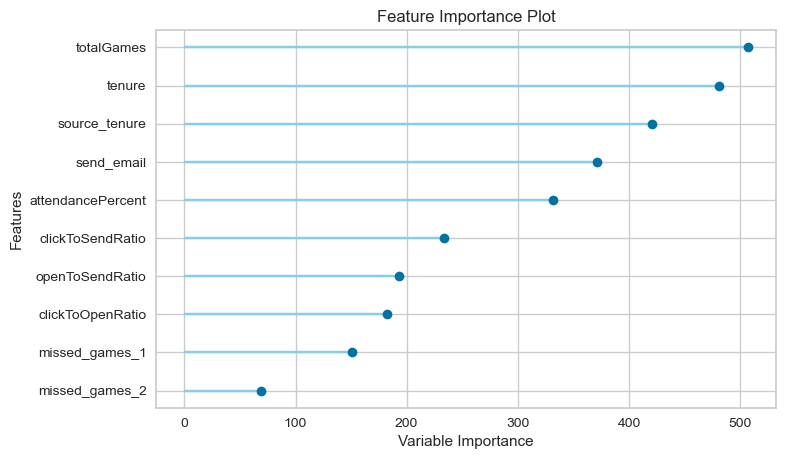

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?